## This notebook performs a K-means clustering of seasonal precipitation curves in the Tibetan Plateau region  

In [112]:
import numpy as np
from sklearn import cluster
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans

import os
import glob 

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

In [137]:
# read in dataset on which the cluster analysis will be performed 
def read_in_netcdf(file):
    from netCDF4 import Dataset
    dataset = Dataset(file)    
    precip= np.array(dataset['precipitationCal'])
    lon= np.array(dataset["lon"])
    lat= np.array(dataset["lat"])
    dataset.close()
    return precip, lon, lat

## Read in data 

In [133]:
# read in average seasonal curve for each grid cell 2000 - 2019 
data= '/media/juli/Data/projects/data/satellite_data/gpm_v06/months_2000_2019/'
file = data + 'gpm_2000_2019_seasonalcurve.nc4'
seasonal_precip, lon, lat = read_in_netcdf(file)

# read in annual mean precipitation for each grid cell 2000 - 2019 
file = data + 'gpm_2000_2019_annualmeans.nc4'
annual_precip, lon, lat = read_in_netcdf(file)
total_annual_mean = np.nanmean(annual_precip, axis= 0)
std_annual_mean = np.nanstd(annual_precip, axis= 0)

# alternativ (which results in different values but exactly the same curves)
total_annual_mean2 = np.nanmean(seasonal_precip, axis= 0)
std_annual_mean2 = np.nanstd(seasonal_precip, axis= 0)


In [236]:
# read in 10 day avg seasonal curve 2000 - 2019 
data= '/media/juli/Elements/gpm_v06/'
import glob

seasonal_precip= np.zeros((401,201))

for i in np.arange(1,365,10):
    file = glob.glob(data + '*_' +str(i) +'_allyears.nc4.nc4')
    print(file)
    precip, lon, lat= read_in_netcdf(file[0])
    seasonal_precip= np.dstack((seasonal_precip,precip[0,:,:]))


['/media/juli/Elements/gpm_v06/gpm_10pentad_1_allyears.nc4.nc4']
['/media/juli/Elements/gpm_v06/gpm_10pentad_11_allyears.nc4.nc4']
['/media/juli/Elements/gpm_v06/gpm_10pentad_21_allyears.nc4.nc4']
['/media/juli/Elements/gpm_v06/gpm_10pentad_31_allyears.nc4.nc4']
['/media/juli/Elements/gpm_v06/gpm_10pentad_41_allyears.nc4.nc4']
['/media/juli/Elements/gpm_v06/gpm_10pentad_51_allyears.nc4.nc4']
['/media/juli/Elements/gpm_v06/gpm_10pentad_61_allyears.nc4.nc4']
['/media/juli/Elements/gpm_v06/gpm_10pentad_71_allyears.nc4.nc4']
['/media/juli/Elements/gpm_v06/gpm_10pentad_81_allyears.nc4.nc4']
['/media/juli/Elements/gpm_v06/gpm_10pentad_91_allyears.nc4.nc4']
['/media/juli/Elements/gpm_v06/gpm_10pentad_101_allyears.nc4.nc4']
['/media/juli/Elements/gpm_v06/gpm_10pentad_111_allyears.nc4.nc4']
['/media/juli/Elements/gpm_v06/gpm_10pentad_121_allyears.nc4.nc4']
['/media/juli/Elements/gpm_v06/gpm_10pentad_131_allyears.nc4.nc4']
['/media/juli/Elements/gpm_v06/gpm_10pentad_141_allyears.nc4.nc4']
['/med

IndexError: list index out of range

In [263]:
# read in annual mean precipitation for each grid cell 2000 - 2019 
file = data + 'annualmean.nc4'
annual_precip, lon, lat = read_in_netcdf(file)
annual= annual_precip[0].T
seasonal_precip= seasonal_precip.T
seasonal_precip.shape

(37, 201, 401)

## Preprocessing: normalization of  monthly values 

In [489]:
# standardize precipitation with annual mean and annual standard deviation 
precip = (seasonal_precip- total_annual_mean)/ std_annual_mean
a= np.nanmean(precip, axis=1)
mean = np.nanmean(a, axis= 1)

In [144]:
# standardize precipitation by calculating the relative contribution to annual precip
contributions= (seasonal_precip*24*30)/ (total_annual_mean*24*365) * 100 
a= np.nanmean(contributions, axis=1 )
contr = np.nanmean(a, axis= 1)

In [159]:
# standardize precipitation by calculating the relative contribution to annual precip
contributions= (seasonal_precip)/ (np.nansum(seasonal_precip, axis = 0 )) * 100 
a= np.nanmean(contributions, axis=1 )
contr = np.nanmean(a, axis= 1)

In [266]:
# standardize precipitation by calculating the relative contribution to annual precip
contributions = seasonal_precip/annual * 100
a= np.nanmean(contributions, axis=2 )
contr = np.nanmean(a, axis= 1)

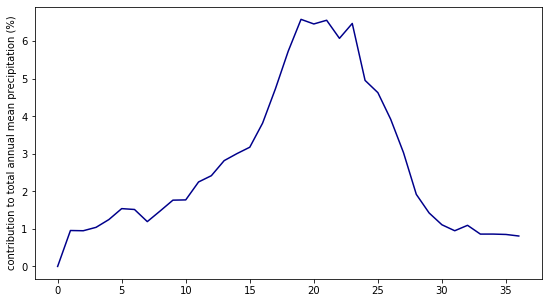

In [268]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(contr, color= 'darkblue')
plt.ylabel('contribution to total annual mean precipitation (%)')

plt.savefig('/media/juli/Data/projects/clusteranalysis_gpm/seasonal_cycle_10days.png')

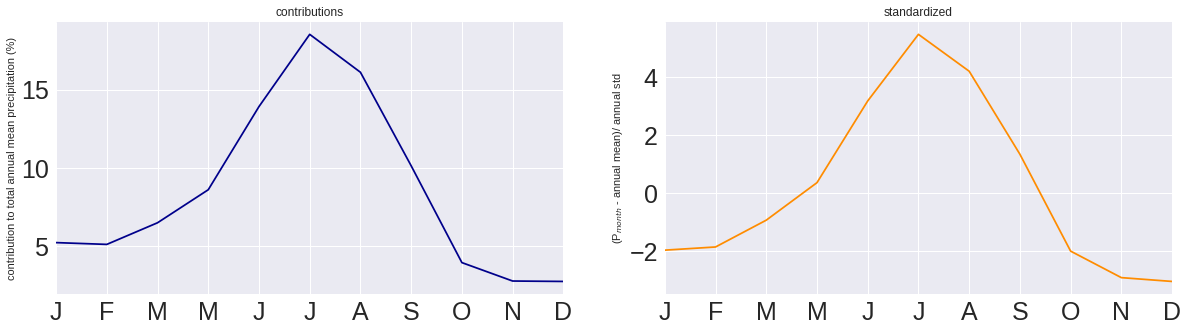

In [432]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(contr, color= 'darkblue')
plt.ylabel('contribution to total annual mean precipitation (%)')
plt.title('contributions')
labels= ['J', 'F', 'M','M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
plt.xticks(np.arange(1,12,1), labels)
plt.xlim(1,11)


plt.subplot(1,2,2)
plt.plot(mean, color='darkorange')
plt.ylabel('(P$_{month}$ - annual mean)/ annual std ')
plt.title('standardized')
labels= ['J', 'F', 'M','M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
plt.xticks(np.arange(1,12,1), labels)
plt.xlim(1,11)

plt.savefig('/media/juli/Data/projects/clusteranalysis_gpm/seasonal_cycle_normalization.png')

In [457]:
# training data for standardized 
nrows= np.shape(precip)[1]
ncols= np.shape(precip)[2]
training_data= np.reshape(precip, (12,nrows*ncols))
training_data= training_data.transpose()
np.shape(training_data)

(80601, 12)

In [509]:
# training data for contributions 
nrows= np.shape(contributions)[1]
ncols= np.shape(contributions)[2]
training_data= np.reshape(contributions, (12,nrows*ncols))
training_data= training_data.transpose()
np.shape(training_data)

(80601, 12)

In [270]:
# training data for contributions, 10 days 
nrows= np.shape(contributions)[1]
ncols= np.shape(contributions)[2]
training_data= np.reshape(contributions, (37,nrows*ncols))
training_data= training_data.transpose()
np.shape(training_data)

(80601, 37)

## K-means clustering 

In [271]:
X = training_data # input matrix shape (n_samples, n_features)
k = 3
kmeans = KMeans(n_clusters= k, random_state=0).fit(X)

# attributes
centers = kmeans.cluster_centers_ # n_clusters x n_features
labels = kmeans.labels_ # contains the actual classes 
cluster_grid= np.reshape(kmeans.labels_, ((nrows,ncols)))

## Plotting outcome

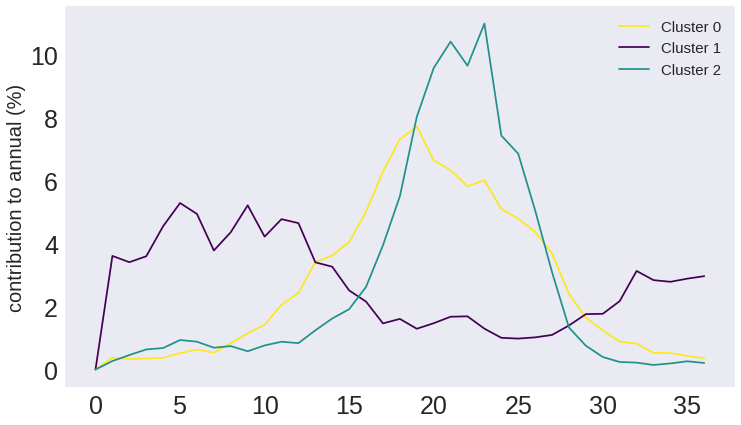

In [274]:
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})
plt.figure(figsize=(12, 7))
plt.ylabel('contribution to annual (%)', fontsize= 20)
#labels= ['J', 'F', 'M','M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
#plt.xticks(np.arange(1,12,1), labels)
plt.grid()
#plt.xlim(1,11)

n = 3
colors = plt.cm.viridis(np.linspace(0,1,n))

plt.plot(kmeans.cluster_centers_[0], label = 'Cluster '+ str(0) , color=colors[2])
plt.plot(kmeans.cluster_centers_[1], label = 'Cluster '+ str(1) , color=colors[0])
plt.plot(kmeans.cluster_centers_[2], label = 'Cluster '+ str(2) , color=colors[1])

plt.legend( prop={'size': 15})
plt.rcParams.update({'font.size': 20})
plt.savefig('cluster_centers3_10days.png')

In [275]:
nunique, counts = np.unique(cluster_grid, return_counts=True)
counts

array([43336, 15300, 21965])

In [477]:
cluster_grid.shape

(401, 201)

In [487]:
# change colors 
for rowidx,row in enumerate(cluster_grid):
    for c,val in enumerate(row):
        if val == 0:
            cluster_grid[rowidx,c]= 2 
        if val == 1:
            cluster_grid[rowidx,c]= 0
        if val == 2:
            cluster_grid[rowidx,c]= 1


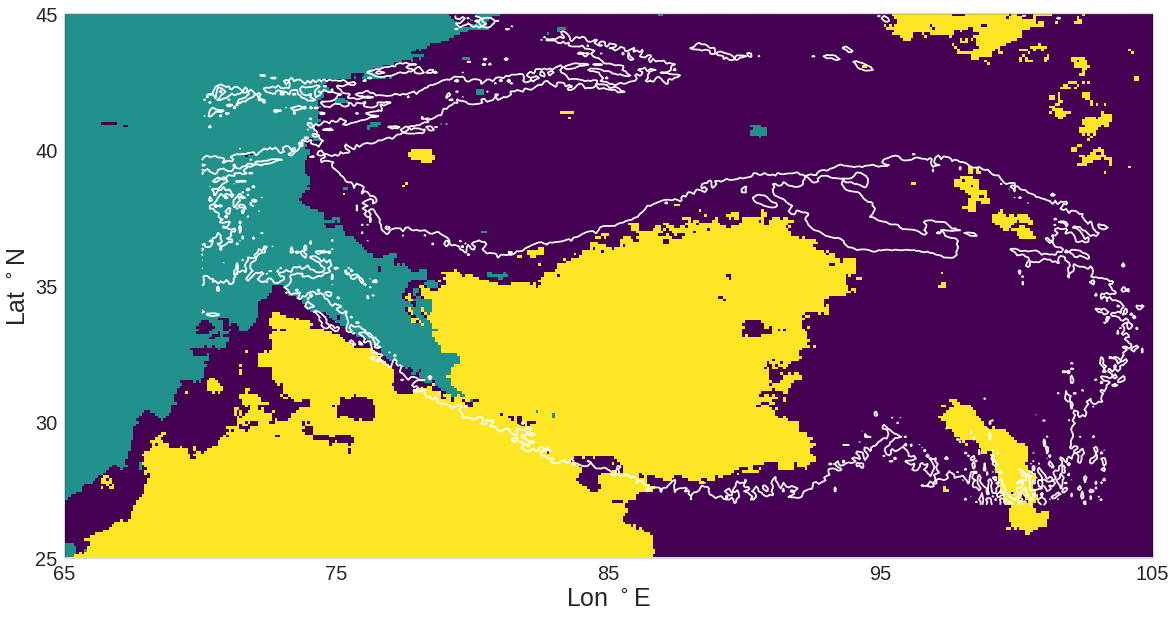

In [277]:


plt.figure(figsize=(20, 10))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([np.nanmin(lon),np.nanmax(lon),np.nanmin(lat),40])

plt.pcolormesh(lon, lat, cluster_grid , transform= ccrs.PlateCarree(), cmap= 'viridis')
# Plot TP boundary polyline from shapefile 
#shapefile='/media/juli/Data/projects/master_thesis/Master_thesis/data/DBATP/DBATP.shp'
#shape_feature = ShapelyFeature(Reader(shapefile).geometries(),ccrs.PlateCarree(), edgecolor='black' , facecolor=None )
#ax.add_feature(shape_feature)

# 3000 m boundary 
plt.contour(lo,la, elevation, [3000])
    

xlabels=[65,75, 85, 95, 105]
ylabels= [25,30, 35, 40,45]
plt.xticks(xlabels, xlabels, fontsize=20)
plt.yticks(ylabels,ylabels, fontsize=20)
plt.xlabel('Lon $^\circ$E',  fontsize=25)
plt.ylabel('Lat $^\circ$N',  fontsize=25)

plt.savefig('3clusters_10days.png')

## Cluster centers and grid cell variability 

How many grid cells have been assigned to each of the three clusters?

In [285]:
row_indices= np.where([cluster_grid == 2])[1]
col_indices= np.where([cluster_grid == 2])[2]
cluster0=contributions[:, row_indices, col_indices].T
subset= cluster0[0:5000,:]

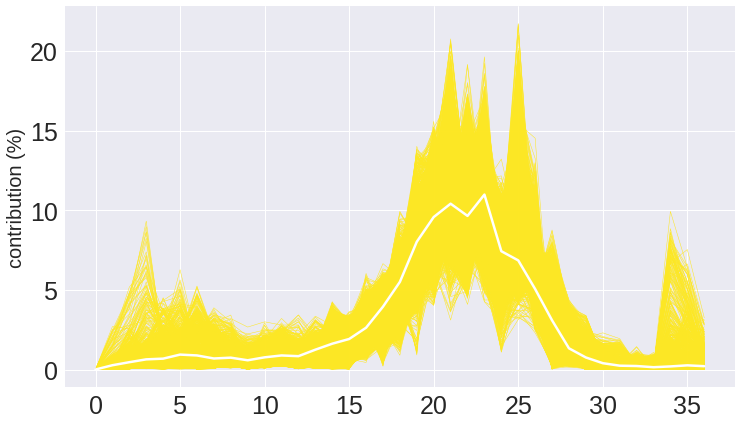

In [286]:
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})
plt.figure(figsize=(12, 7))
plt.ylabel('contribution (%)', fontsize= 20)
#labels= ['J', 'F', 'M','M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
#plt.xticks(np.arange(1,12,1), labels)
#plt.xlim(1,11)
#plt.ylim(0,45)

for i in subset:
    plt.plot(i,  color=colors[2], linewidth= 0.5)

plt.plot(kmeans.cluster_centers_[2], color='white', linewidth= 2.5)
plt.savefig('cluster2_allgridcells_10days.png')

## Interannual variability 

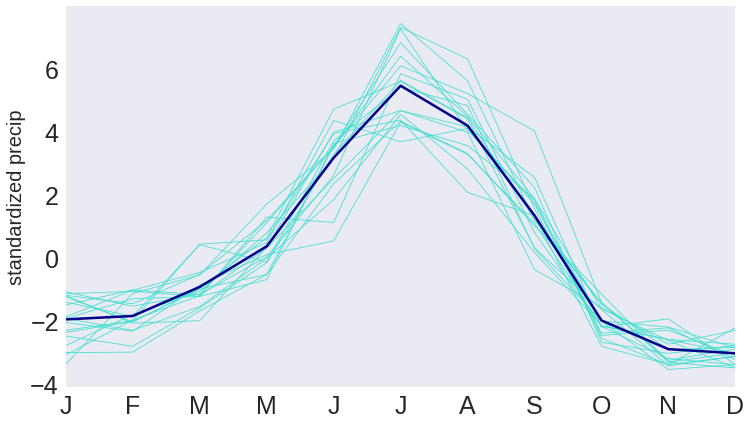

In [438]:
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})
plt.figure(figsize=(12, 7))
plt.ylabel('standardized precip', fontsize= 20)
labels= ['J', 'F', 'M','M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
plt.xticks(np.arange(1,12,1), labels)
plt.xlim(1,11)

for year in np.arange(2001,2019):
    prec, lon, lat= read_in_netcdf(data +'seasonal_'+str(year)+'.nc4')
    #prec= (prec*24*30)/ (np.nanmean(prec, axis = 0)*24*365) * 100 
    prec = (prec- total_annual_mean)/ std_annual_mean
    seasonal= np.nanmean(prec, axis= 1)
    seasonal_domain= np.nanmean(seasonal, axis= 1)
    plt.plot(seasonal_domain,color= 'turquoise', linewidth= 0.8)
    
plt.plot(mean, color='darkblue', linewidth= 2.5)
plt.grid()
plt.savefig('seasonal_curve_std_interannual_variability.png')

## Prediction  for each year - heatmaps

How many years have the grid points been assigned to cluster 1, 2, 3 ? 

In [331]:
precip.shape

(12, 401, 201)

In [353]:
# predict the cluster for each year 
counts1= np.zeros((nrows*ncols))
counts2= np.zeros((nrows*ncols))
counts3= np.zeros((nrows*ncols))

for year in np.arange(2001,2019):
    prec, lon, lat= read_in_netcdf(data +'seasonal_'+str(year)+'.nc4')
    contributions= (prec*24*30)/ (np.nanmean(prec, axis = 0)*24*365) * 100 
    prec_year= np.reshape(contributions.T, (ncols*nrows, 12))
    #prec_year= np.reshape(precip, ( nrows*ncols, 12))
    predictions= kmeans.predict(prec_year)
    counts1[predictions == 0]+= 1 
    counts2[predictions == 1]+= 1 
    counts3[predictions == 2]+= 1

predict1= np.reshape(counts1, (ncols,nrows)) #/18 * 100
predict2= np.reshape(counts2, (ncols,nrows)) #/18 * 100  
predict3= np.reshape(counts3, (ncols,nrows)) #/ 18 * 100 

In [16]:
# dem in GPM resolution 
from netCDF4 import Dataset
dem = '/media/juli/Data/projects/master_thesis/Master_thesis/data/DEM_TP/dem_GPM_format.nc'
ds = Dataset(dem)
elevation = np.array(ds['__xarray_dataarray_variable__'])
f= '/media/juli/Data/projects/data/satellite_data/gpm_v06/monthly_means/gpm_mean_201506.nc4'
gpm= Dataset(f)
lo = np.array(gpm['lon'])
la = np.array(gpm['lat'])


#plt.contour(lo,la, elevation, [3000])

In [361]:
def heat_map(predict, out, cluster):
    plt.figure(figsize=(12,5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([np.nanmin(lon),np.nanmax(lon),np.nanmin(lat),40])
    
    # 3000 m boundary 
    plt.contour(lo,la, elevation, [3000])
    
    # define the bins and normalize
    import matplotlib.colors as colors
    cmap=plt.cm.viridis
    norm = colors.BoundaryNorm(np.arange(0,20), cmap.N)
    m = plt.pcolormesh(lon, lat, predict , transform= ccrs.PlateCarree(), cmap= 'viridis', norm=norm )

    xlabels=[65,75, 85, 95, 105]
    ylabels= [25, 35, 45]
    plt.xticks(xlabels, xlabels, fontsize=20)
    plt.yticks(ylabels,ylabels, fontsize=20)
    plt.xlabel('Lon $^\circ$E',  fontsize=25)
    plt.ylabel('Lat $^\circ$N',  fontsize=25)
    
    cbar= plt.colorbar(m)
    #cbar.set_ticks([0,3,6,9,12,15,19])
    cbar.set_label('# years with cluster'+ str(cluster), fontsize= 25)

    plt.savefig(out)

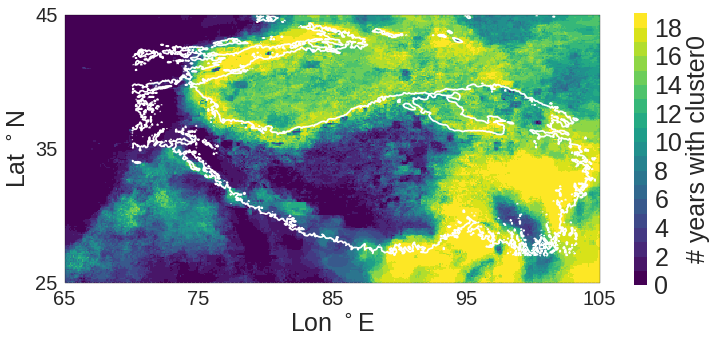

In [362]:
heat_map(predict1, 'heatmap_cluster0.png', 0)

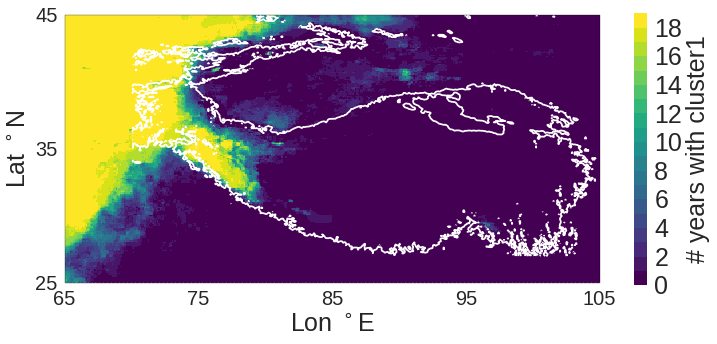

In [363]:
heat_map(predict2, 'heatmap_cluster1.png', 1)

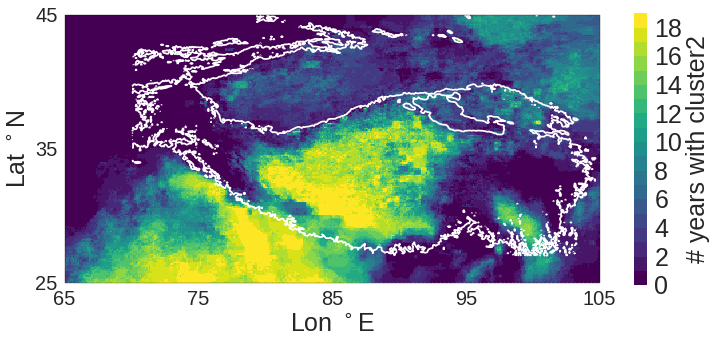

In [364]:
heat_map(predict3, 'heatmap_cluster2.png', 2)

## 10 pentad average for monsoon evolution 

In [103]:
file = '/media/juli/Elements/gpm_v06/gpm_2016_10pentad_212.nc4'
precip, lon,lat = read_in_netcdf(file, "precipitationCal")
precip= precip[0].T
precip[precip< 1] = np.nan


gpm_10pentad_262.nc4
gpm_10pentad_122.nc4
gpm_10pentad_132.nc4
gpm_10pentad_142.nc4
gpm_10pentad_152.nc4
gpm_10pentad_162.nc4
gpm_10pentad_172.nc4
gpm_10pentad_182.nc4
gpm_10pentad_192.nc4
gpm_10pentad_202.nc4
gpm_10pentad_212.nc4
gpm_10pentad_222.nc4
gpm_10pentad_232.nc4
gpm_10pentad_242.nc4
gpm_10pentad_252.nc4
gpm_10pentad_272.nc4
gpm_10pentad_merged.n


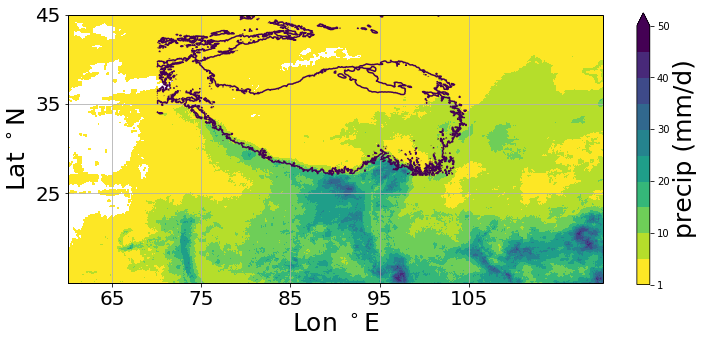

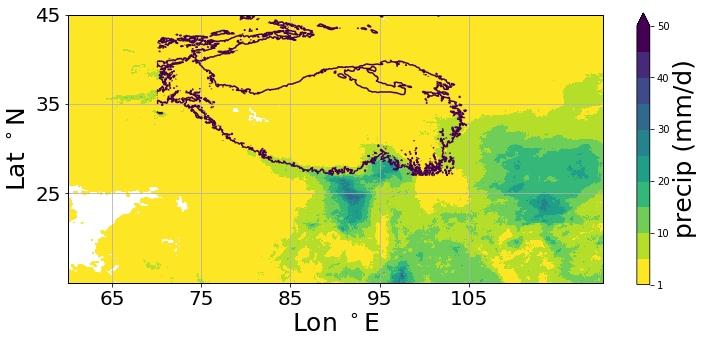

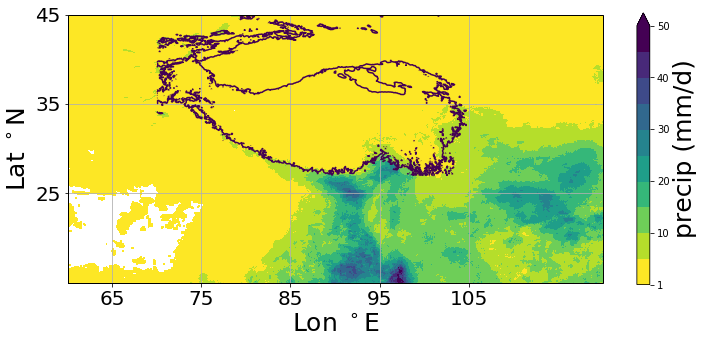

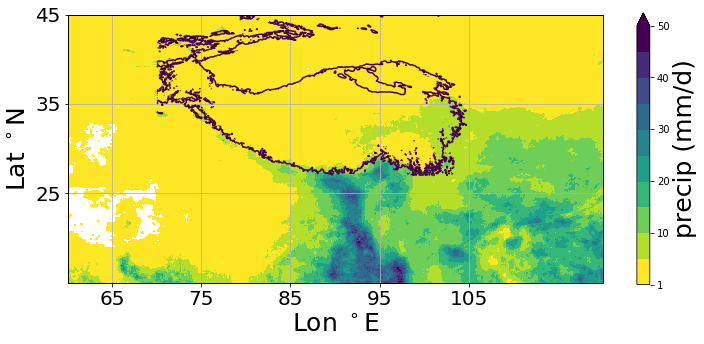

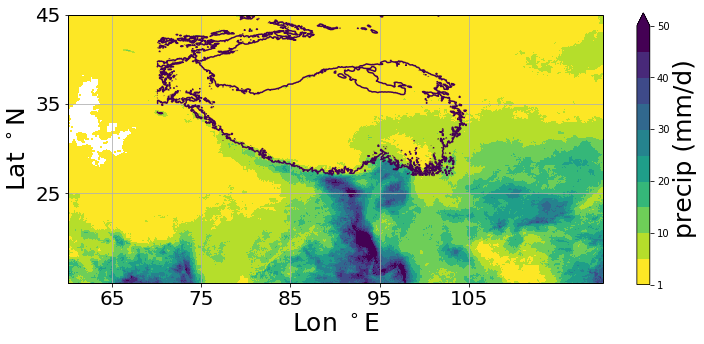

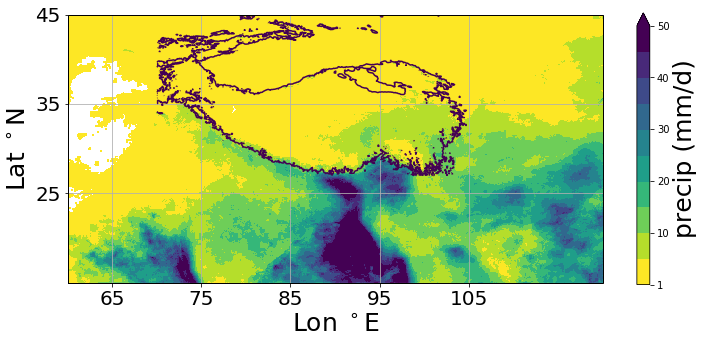

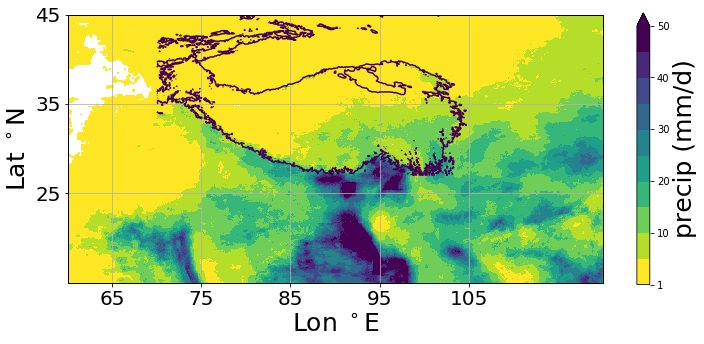

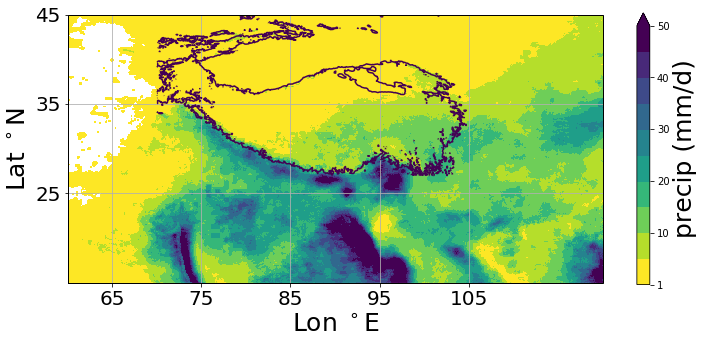

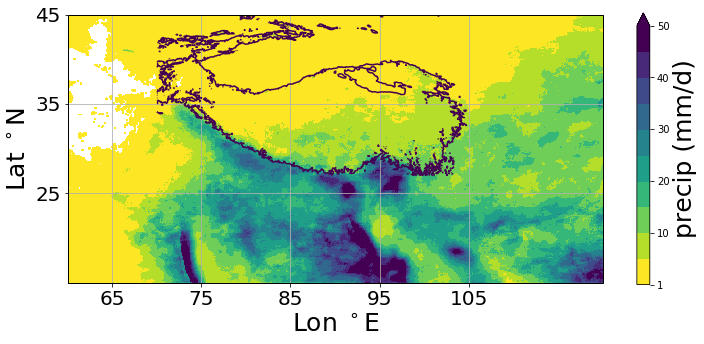

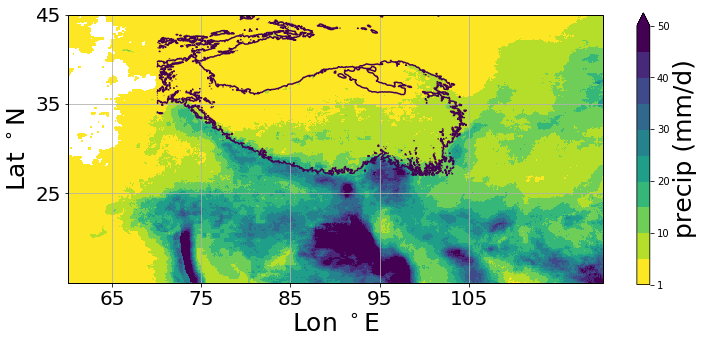

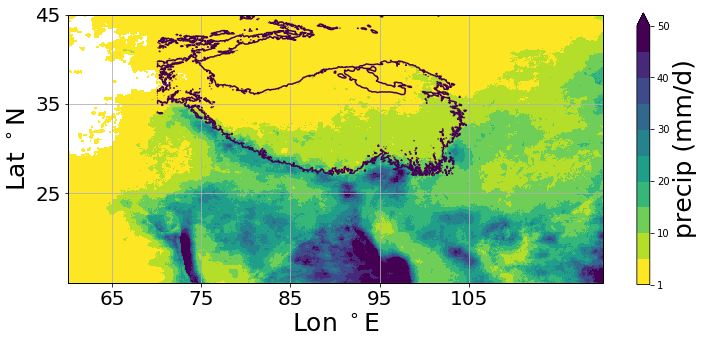

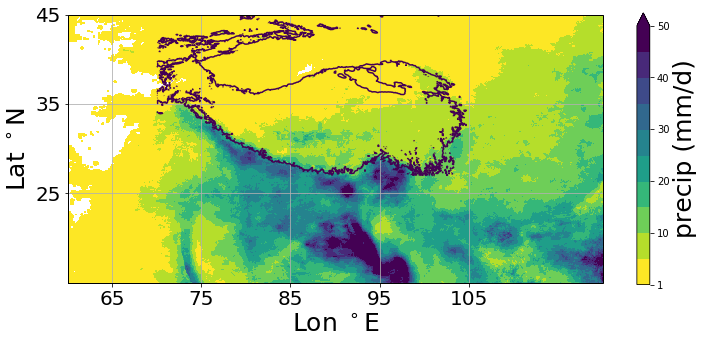

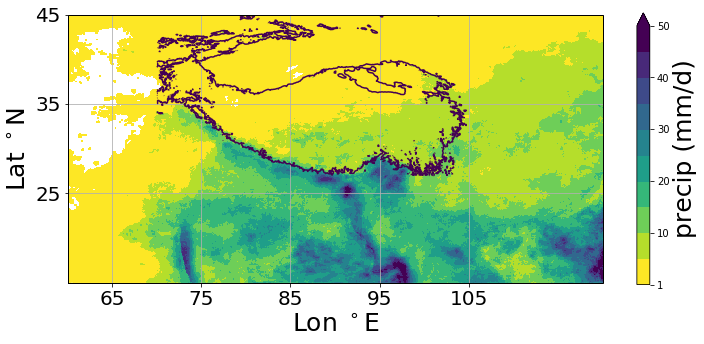

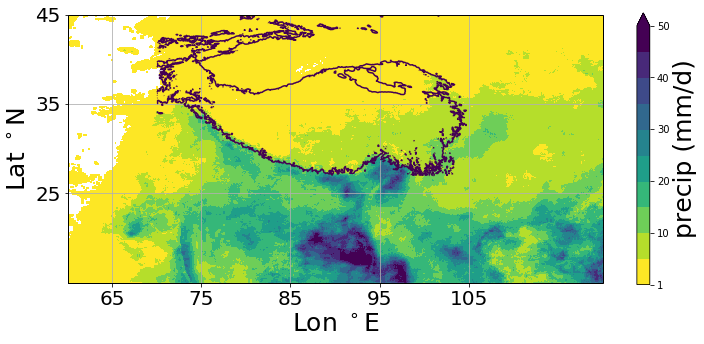

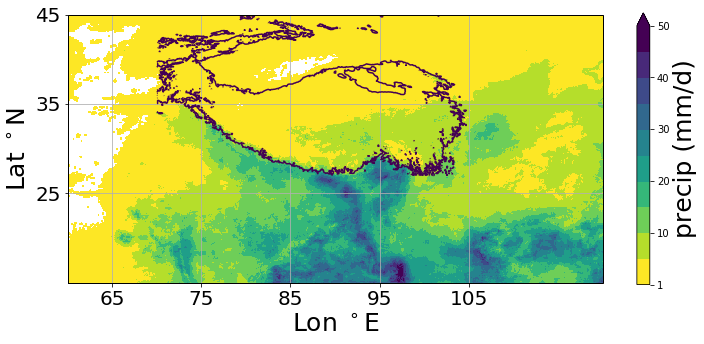

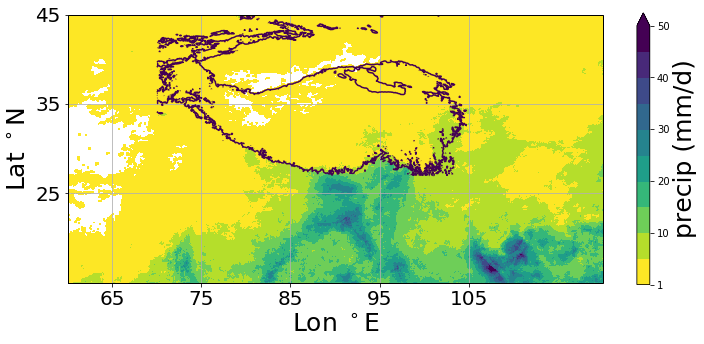

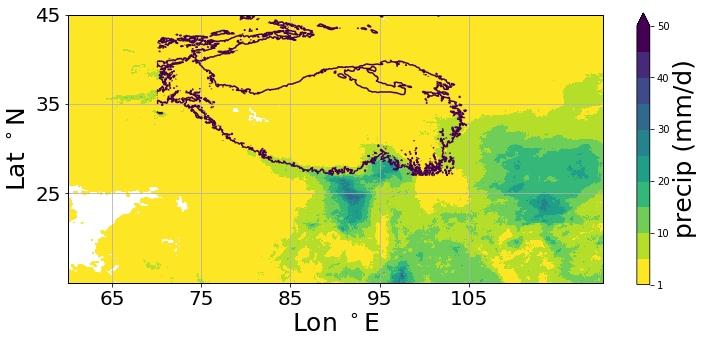

In [111]:
import glob
files= glob.glob('/media/juli/Elements/gpm_v06/gpm_10pentad_*.nc4')

for f in files:
    filename= f[29:50]
    print(filename)
    precip, lon,lat = read_in_netcdf(f, "precipitationCal")
    precip= precip[0].T
    precip[precip< 1] = np.nan
    rainmap(precip, filename)
   

In [110]:
def rainmap(precip, filename):
    plt.figure(figsize=(12,5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([np.nanmin(lon),np.nanmax(lon),np.nanmin(lat),40])

    # 3000 m boundary 
    plt.contour(lo,la, elevation, [3000])

    # define the bins and normalize
    import matplotlib.colors as colors
    cmap=plt.cm.viridis
    norm = colors.BoundaryNorm([1, 5, 10,15,20,25,30,35,40,45, 50], cmap.N)
    m = plt.pcolormesh(lon, lat, precip/10, transform= ccrs.PlateCarree(), cmap= 'viridis_r', norm=norm)
    cmap=plt.cm.viridis
    cmap.set_under('lightyellow')
    cmap.set_bad('lightyellow')

    xlabels=[65,75, 85, 95, 105]
    ylabels= [25, 35, 45]
    plt.xticks(xlabels, xlabels, fontsize=20)
    plt.yticks(ylabels,ylabels, fontsize=20)
    plt.xlabel('Lon $^\circ$E',  fontsize=25)
    plt.ylabel('Lat $^\circ$N',  fontsize=25)


    cbar= plt.colorbar(m, extend='max')
    cbar.set_label('precip (mm/d)', fontsize= 25)
    plt.grid()
    plt.savefig('/media/juli/Data/projects/clusteranalysis_gpm/monsoon_evolution/merged_years/'+filename +'.png')
